## Import Libs

In [500]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

## Read CSV

In [501]:
df = pd.read_csv('account_receivable.csv')
df.head()

,countryCode,customerID,PaperlessDate,invoiceNumber,InvoiceDate,DueDate,InvoiceAmount,Disputed,SettledDate,PaperlessBill,DaysToSettle,DaysLate
0,391,0379-NEVHP,4/6/2013,611365,1/2/2013,2/1/2013,55.94,No,1/15/2013,Paper,13,0
1,406,8976-AMJEO,3/3/2012,7900770,1/26/2013,2/25/2013,61.74,Yes,3/3/2013,Electronic,36,6
2,391,2820-XGXSB,1/26/2012,9231909,7/3/2013,8/2/2013,65.88,No,7/8/2013,Electronic,5,0
3,406,9322-YCTQO,4/6/2012,9888306,2/10/2013,3/12/2013,105.92,No,3/17/2013,Electronic,35,5
4,818,6627-ELFBK,11/26/2012,15752855,10/25/2012,11/24/2012,72.27,Yes,11/28/2012,Paper,34,4


In [502]:
df.shape

(2466, 12)

## Data Cleaning

In [503]:
# Check missing value
df.isna().sum()


countryCode      0
customerID       0
PaperlessDate    0
invoiceNumber    0
InvoiceDate      0
DueDate          0
InvoiceAmount    0
Disputed         0
SettledDate      0
PaperlessBill    0
DaysToSettle     0
DaysLate         0
dtype: int64

In [504]:
# Check duplicate
df.duplicated().sum()

0

## Data Wrangling

### Rename Columns to Increase Readability

In [505]:
columns_map = {'countryCode':'country_code',
               'customerID':'customer_id',
               'PaperlessDate':'paperless_date',
               'invoiceNumber':'invoice_number',
               'InvoiceDate':'invoice_date',
               'DueDate':'due_date',
               'InvoiceAmount':'invoice_amount',
               'Disputed':'is_disputed',
               'SettledDate':'settled_date',
               'PaperlessBill':'is_paperless',
               'DaysToSettle':'days_to_settle',
               'DaysLate':'days_late'
               }

df.rename(columns = columns_map, inplace = True)
df.head()

,country_code,customer_id,paperless_date,invoice_number,invoice_date,due_date,invoice_amount,is_disputed,settled_date,is_paperless,days_to_settle,days_late
0,391,0379-NEVHP,4/6/2013,611365,1/2/2013,2/1/2013,55.94,No,1/15/2013,Paper,13,0
1,406,8976-AMJEO,3/3/2012,7900770,1/26/2013,2/25/2013,61.74,Yes,3/3/2013,Electronic,36,6
2,391,2820-XGXSB,1/26/2012,9231909,7/3/2013,8/2/2013,65.88,No,7/8/2013,Electronic,5,0
3,406,9322-YCTQO,4/6/2012,9888306,2/10/2013,3/12/2013,105.92,No,3/17/2013,Electronic,35,5
4,818,6627-ELFBK,11/26/2012,15752855,10/25/2012,11/24/2012,72.27,Yes,11/28/2012,Paper,34,4


1. countryCode --> Ubah jadi categorical data
2. customerID --> Hmm diapakan enaknya? (HAPUS)
3. PaperlessDate --> breakdown jadi tahun dan bulan --> cek apakah terjadi sebelum atau sesudah InvoiceDate --> convert to sin & cos val
4. invoiceNumber --> Ubah jadi categorical data (HAPUS)
5. InvoiceDate --> breakdown jadi tahun dan bulan --> convert to sin & cos val
6. DueDate --> breakdown jadi tahun dan bulan --> convert to sin & cos val
7. InvoiceAmount --> kept as-is (numerical)
8. Disputed --> Categorical
9. SettledDate --> Hapus (data leak) (HAPUS)
10. PaperlessBill --> categorical
11. DaystoSettle --> Hapus (data leak) (HAPUS)
12. DaysLate --> ubah jadi 1 or 0 (jadi target)

### Convert days_late (target) into Categorical Data

In [506]:
def label_is_on_time(data, column):
    if data[column] > 0:
        return 0
    else:
        return 1 

In [507]:
df['is_on_time'] = df.apply(label_is_on_time, args=('days_late', ), axis=1)
df.head()

,country_code,customer_id,paperless_date,invoice_number,invoice_date,due_date,invoice_amount,is_disputed,settled_date,is_paperless,days_to_settle,days_late,is_on_time
0,391,0379-NEVHP,4/6/2013,611365,1/2/2013,2/1/2013,55.94,No,1/15/2013,Paper,13,0,1
1,406,8976-AMJEO,3/3/2012,7900770,1/26/2013,2/25/2013,61.74,Yes,3/3/2013,Electronic,36,6,0
2,391,2820-XGXSB,1/26/2012,9231909,7/3/2013,8/2/2013,65.88,No,7/8/2013,Electronic,5,0,1
3,406,9322-YCTQO,4/6/2012,9888306,2/10/2013,3/12/2013,105.92,No,3/17/2013,Electronic,35,5,0
4,818,6627-ELFBK,11/26/2012,15752855,10/25/2012,11/24/2012,72.27,Yes,11/28/2012,Paper,34,4,0


In [508]:
df['is_on_time'].value_counts(normalize=True)

is_on_time
1    0.644363
0    0.355637
Name: proportion, dtype: float64

### Convert is_disputed into Categorical Data

In [509]:
def label_is_disputed(data, column):
    if data[column] == 'Yes':
        return 1
    else:
        return 0

In [510]:
df['is_disputed'] = df.apply(label_is_disputed, args=('is_disputed', ), axis=1)
df.head()

,country_code,customer_id,paperless_date,invoice_number,invoice_date,due_date,invoice_amount,is_disputed,settled_date,is_paperless,days_to_settle,days_late,is_on_time
0,391,0379-NEVHP,4/6/2013,611365,1/2/2013,2/1/2013,55.94,0,1/15/2013,Paper,13,0,1
1,406,8976-AMJEO,3/3/2012,7900770,1/26/2013,2/25/2013,61.74,1,3/3/2013,Electronic,36,6,0
2,391,2820-XGXSB,1/26/2012,9231909,7/3/2013,8/2/2013,65.88,0,7/8/2013,Electronic,5,0,1
3,406,9322-YCTQO,4/6/2012,9888306,2/10/2013,3/12/2013,105.92,0,3/17/2013,Electronic,35,5,0
4,818,6627-ELFBK,11/26/2012,15752855,10/25/2012,11/24/2012,72.27,1,11/28/2012,Paper,34,4,0


### Get Dummies out of Categorical Data

In [511]:
def get_dummies(data, columns):
    data = pd.get_dummies(data, columns=columns, drop_first=True, dtype=int)
    
    return data

In [512]:
df = get_dummies(df, ['country_code'])
df.head()

,customer_id,paperless_date,invoice_number,invoice_date,due_date,invoice_amount,is_disputed,settled_date,is_paperless,days_to_settle,days_late,is_on_time,country_code_406,country_code_770,country_code_818,country_code_897
0,0379-NEVHP,4/6/2013,611365,1/2/2013,2/1/2013,55.94,0,1/15/2013,Paper,13,0,1,0,0,0,0
1,8976-AMJEO,3/3/2012,7900770,1/26/2013,2/25/2013,61.74,1,3/3/2013,Electronic,36,6,0,1,0,0,0
2,2820-XGXSB,1/26/2012,9231909,7/3/2013,8/2/2013,65.88,0,7/8/2013,Electronic,5,0,1,0,0,0,0
3,9322-YCTQO,4/6/2012,9888306,2/10/2013,3/12/2013,105.92,0,3/17/2013,Electronic,35,5,0,1,0,0,0
4,6627-ELFBK,11/26/2012,15752855,10/25/2012,11/24/2012,72.27,1,11/28/2012,Paper,34,4,0,0,0,1,0


### Get Dummies out of is_paperless

In [513]:
def label_is_paperless(data, column):
    if data[column] == 'Electronic':
        return 1
    else:
        return 0 

In [514]:
df['is_paperless'] = df.apply(label_is_paperless, args=('is_paperless', ), axis=1)
df.head()

,customer_id,paperless_date,invoice_number,invoice_date,due_date,invoice_amount,is_disputed,settled_date,is_paperless,days_to_settle,days_late,is_on_time,country_code_406,country_code_770,country_code_818,country_code_897
0,0379-NEVHP,4/6/2013,611365,1/2/2013,2/1/2013,55.94,0,1/15/2013,0,13,0,1,0,0,0,0
1,8976-AMJEO,3/3/2012,7900770,1/26/2013,2/25/2013,61.74,1,3/3/2013,1,36,6,0,1,0,0,0
2,2820-XGXSB,1/26/2012,9231909,7/3/2013,8/2/2013,65.88,0,7/8/2013,1,5,0,1,0,0,0,0
3,9322-YCTQO,4/6/2012,9888306,2/10/2013,3/12/2013,105.92,0,3/17/2013,1,35,5,0,1,0,0,0
4,6627-ELFBK,11/26/2012,15752855,10/25/2012,11/24/2012,72.27,1,11/28/2012,0,34,4,0,0,0,1,0


### Remove Unnecessary and Potential-to-Leak Data

In [515]:
columns = ['customer_id', 'invoice_number', 'settled_date', 'days_to_settle', 'days_late']
df = df.drop(columns, axis=1)
df.head()

,paperless_date,invoice_date,due_date,invoice_amount,is_disputed,is_paperless,is_on_time,country_code_406,country_code_770,country_code_818,country_code_897
0,4/6/2013,1/2/2013,2/1/2013,55.94,0,0,1,0,0,0,0
1,3/3/2012,1/26/2013,2/25/2013,61.74,1,1,0,1,0,0,0
2,1/26/2012,7/3/2013,8/2/2013,65.88,0,1,1,0,0,0,0
3,4/6/2012,2/10/2013,3/12/2013,105.92,0,1,0,1,0,0,0
4,11/26/2012,10/25/2012,11/24/2012,72.27,1,0,0,0,0,1,0


### Convert Data to Date

In [516]:
def convert_to_date(data, *columns):
    for col in columns:
        data[col] = pd.to_datetime(data[col].stack()).unstack()
    
    return data

In [517]:
df = convert_to_date(df,['paperless_date','invoice_date', 'due_date'])

In [518]:
df.dtypes

paperless_date      datetime64[ns]
invoice_date        datetime64[ns]
due_date            datetime64[ns]
invoice_amount             float64
is_disputed                  int64
is_paperless                 int64
is_on_time                   int64
country_code_406             int64
country_code_770             int64
country_code_818             int64
country_code_897             int64
dtype: object

### Get a label to indicate if the paperless is before or after the invoice date

In [519]:
def label_is_date_later(data, column_1, column_2):
    if data[column_1] > data[column_2]:
        return 1
    else:
        return 0 

In [520]:
df['is_paperless_later'] = df.apply(label_is_date_later, args=('paperless_date', 'invoice_date'), axis=1)
df.head()

,paperless_date,invoice_date,due_date,invoice_amount,is_disputed,is_paperless,is_on_time,country_code_406,country_code_770,country_code_818,country_code_897,is_paperless_later
0,2013-04-06,2013-01-02,2013-02-01,55.94,0,0,1,0,0,0,0,1
1,2012-03-03,2013-01-26,2013-02-25,61.74,1,1,0,1,0,0,0,0
2,2012-01-26,2013-07-03,2013-08-02,65.88,0,1,1,0,0,0,0,0
3,2012-04-06,2013-02-10,2013-03-12,105.92,0,1,0,1,0,0,0,0
4,2012-11-26,2012-10-25,2012-11-24,72.27,1,0,0,0,0,1,0,1


### Get the Month and Day of Week of the Date

In [521]:
def get_m_dow(data, column):
    month = data[column].dt.strftime('%m').astype(int)
    day = data[column].dt.strftime('%w').astype(int)
    data = data.drop(column, axis=1)
    
    return data, month, day
    

In [522]:
# Get the Year, Month, and Day of Weekk of Paperless Date
df, df['paperless_month'], df['paperless_dow'] = get_m_dow(df, 'paperless_date')
df.head()

,invoice_date,due_date,invoice_amount,is_disputed,is_paperless,is_on_time,country_code_406,country_code_770,country_code_818,country_code_897,is_paperless_later,paperless_month,paperless_dow
0,2013-01-02,2013-02-01,55.94,0,0,1,0,0,0,0,1,4,6
1,2013-01-26,2013-02-25,61.74,1,1,0,1,0,0,0,0,3,6
2,2013-07-03,2013-08-02,65.88,0,1,1,0,0,0,0,0,1,4
3,2013-02-10,2013-03-12,105.92,0,1,0,1,0,0,0,0,4,5
4,2012-10-25,2012-11-24,72.27,1,0,0,0,0,1,0,1,11,1


In [523]:
# Get the Year, Month, and Day of Weekk of Invoice Date
df, df['invoice_month'], df['invoice_dow'] = get_m_dow(df, 'invoice_date')
df.head()

,due_date,invoice_amount,is_disputed,is_paperless,is_on_time,country_code_406,country_code_770,country_code_818,country_code_897,is_paperless_later,paperless_month,paperless_dow,invoice_month,invoice_dow
0,2013-02-01,55.94,0,0,1,0,0,0,0,1,4,6,1,3
1,2013-02-25,61.74,1,1,0,1,0,0,0,0,3,6,1,6
2,2013-08-02,65.88,0,1,1,0,0,0,0,0,1,4,7,3
3,2013-03-12,105.92,0,1,0,1,0,0,0,0,4,5,2,0
4,2012-11-24,72.27,1,0,0,0,0,1,0,1,11,1,10,4


In [524]:
# Get the Year, Month, and Day of Weekk of Due Date
df, df['due_month'], df['due_dow'] = get_m_dow(df, 'due_date')
df.head()

,invoice_amount,is_disputed,is_paperless,is_on_time,country_code_406,country_code_770,country_code_818,country_code_897,is_paperless_later,paperless_month,paperless_dow,invoice_month,invoice_dow,due_month,due_dow
0,55.94,0,0,1,0,0,0,0,1,4,6,1,3,2,5
1,61.74,1,1,0,1,0,0,0,0,3,6,1,6,2,1
2,65.88,0,1,1,0,0,0,0,0,1,4,7,3,8,5
3,105.92,0,1,0,1,0,0,0,0,4,5,2,0,3,2
4,72.27,1,0,0,0,0,1,0,1,11,1,10,4,11,6


### Convert Cyclical Data (Month & Day of Week) into a Sine and Cosine Value

Reference: </br>
- https://www.ideadrops.info/post/how-to-encode-cyclic-time
- https://webcache.googleusercontent.com/search?q=cache:https://towardsdatascience.com/stop-one-hot-encoding-your-time-based-features-24c699face2f



In [525]:
# # Define a function to get the sin and cos value of a column
# def get_sin_cos(data, column):
#     sin_col_name = column + '_sin'
#     cos_col_name = column + '_cos'
#     data[sin_col_name] = data[column].apply(math.sin)
#     data[cos_col_name] = data[column].apply(math.cos)
    
#     data = data.drop(column, axis=1)
    
#     return data

In [526]:
# cyclical_columns = [
#     'paperless_month',
#     'paperless_dow',
#     'invoice_month',
#     'invoice_dow',
#     'due_month',
#     'due_dow'
# ]

In [527]:
# for i in cyclical_columns:
#     df = get_sin_cos(df, i)

In [528]:
# Define a function to get the sin and cos value of a column
def get_sin_cos_month(data, column):
    sin_col_name = column + '_sin'
    cos_col_name = column + '_cos'
    data[sin_col_name] = np.sin(data[column]*(2.*np.pi/12))
    data[cos_col_name] = np.cos(data[column]*(2.*np.pi/12))
    
    data = data.drop(column, axis=1)
    
    return data

In [529]:
# Define a function to get the sin and cos value of a column
def get_sin_cos_dow(data, column):
    sin_col_name = column + '_sin'
    cos_col_name = column + '_cos'
    data[sin_col_name] = np.sin(data[column]*(2.*np.pi/7))
    data[cos_col_name] = np.cos(data[column]*(2.*np.pi/7))
    
    data = data.drop(column, axis=1)
    
    return data

In [530]:
cyclical_month_columns = [
    'paperless_month',
    'invoice_month',
    'due_month'
]

cyclical_dow_columns = [
    'paperless_dow',
    'invoice_dow',
    'due_dow'
]

In [531]:
for i in cyclical_month_columns:
    df = get_sin_cos_month(df, i)

In [532]:
for i in cyclical_dow_columns:
    df = get_sin_cos_dow(df, i)

In [533]:
df.head()

,invoice_amount,is_disputed,is_paperless,is_on_time,country_code_406,country_code_770,country_code_818,country_code_897,is_paperless_later,paperless_month_sin,...,invoice_month_sin,invoice_month_cos,due_month_sin,due_month_cos,paperless_dow_sin,paperless_dow_cos,invoice_dow_sin,invoice_dow_cos,due_dow_sin,due_dow_cos
0,55.94,0,0,1,0,0,0,0,1,0.866025,...,0.500000,0.866025,0.866025,5.000000e-01,-0.781831,0.623490,0.433884,-0.900969,-0.974928,-0.222521
1,61.74,1,1,0,1,0,0,0,0,1.000000,...,0.500000,0.866025,0.866025,5.000000e-01,-0.781831,0.623490,-0.781831,0.623490,0.781831,0.623490
2,65.88,0,1,1,0,0,0,0,0,0.500000,...,-0.500000,-0.866025,-0.866025,-5.000000e-01,-0.433884,-0.900969,0.433884,-0.900969,-0.974928,-0.222521
3,105.92,0,1,0,1,0,0,0,0,0.866025,...,0.866025,0.500000,1.000000,6.123234e-17,-0.974928,-0.222521,0.000000,1.000000,0.974928,-0.222521
4,72.27,1,0,0,0,0,1,0,1,-0.500000,...,-0.866025,0.500000,-0.500000,8.660254e-01,0.781831,0.623490,-0.433884,-0.900969,-0.781831,0.623490


## Split Input-Output

In [534]:
def extract_input_output(data,
                       output_column_name):
    """
    Fungsi untuk memisahkan data input dan output
    :param data: <pandas dataframe> data seluruh sample
    :param output_column_name: <string> nama kolom output
    :return input_data: <pandas dataframe> data input
    :return output_data: <pandas series> data output
    """
    output_data = data[output_column_name]
    input_data = data.drop(output_column_name,
                           axis = 1)
    
    return input_data, output_data

In [535]:
X, y = extract_input_output(data = df,
                          output_column_name = "is_on_time")

In [536]:
X.head()

,invoice_amount,is_disputed,is_paperless,country_code_406,country_code_770,country_code_818,country_code_897,is_paperless_later,paperless_month_sin,paperless_month_cos,invoice_month_sin,invoice_month_cos,due_month_sin,due_month_cos,paperless_dow_sin,paperless_dow_cos,invoice_dow_sin,invoice_dow_cos,due_dow_sin,due_dow_cos
0,55.94,0,0,0,0,0,0,1,0.866025,-5.000000e-01,0.500000,0.866025,0.866025,5.000000e-01,-0.781831,0.623490,0.433884,-0.900969,-0.974928,-0.222521
1,61.74,1,1,1,0,0,0,0,1.000000,6.123234e-17,0.500000,0.866025,0.866025,5.000000e-01,-0.781831,0.623490,-0.781831,0.623490,0.781831,0.623490
2,65.88,0,1,0,0,0,0,0,0.500000,8.660254e-01,-0.500000,-0.866025,-0.866025,-5.000000e-01,-0.433884,-0.900969,0.433884,-0.900969,-0.974928,-0.222521
3,105.92,0,1,1,0,0,0,0,0.866025,-5.000000e-01,0.866025,0.500000,1.000000,6.123234e-17,-0.974928,-0.222521,0.000000,1.000000,0.974928,-0.222521
4,72.27,1,0,0,0,1,0,1,-0.500000,8.660254e-01,-0.866025,0.500000,-0.500000,8.660254e-01,0.781831,0.623490,-0.433884,-0.900969,-0.781831,0.623490


In [537]:
y.head()

0    1
1    0
2    1
3    0
4    0
Name: is_on_time, dtype: int64

## Split Train-Test

In [538]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.25,
                                                    random_state = 12)

In [539]:
# Sanity check the split result
print(X_train.shape)
print(X_test.shape)

(1849, 20)
(617, 20)


In [540]:
# Ratio
X_test.shape[0] / X.shape[0]

# Hasil 0.25 - sesuai dengan test_size kita

0.2502027575020276

## EDA di Train Dataset

## Standardize the Data

In [541]:
# Buat fungsi
def data_standardizer(data):
    """
    Fungsi untuk melakukan standarisasi data
    :param data: <pandas dataframe> sampel data
    :return standardized_data: <pandas dataframe> sampel data standard
    :return standardizer: method untuk standardisasi data
    """
    data_columns = data.columns  # agar nama kolom tidak hilang
    data_index = data.index  # agar index tidak hilang

    # buat (fit) standardizer
    standardizer = StandardScaler()
    standardizer.fit(data)

    # transform data
    standardized_data_raw = standardizer.transform(data)
    standardized_data = pd.DataFrame(standardized_data_raw)
    standardized_data.columns = data_columns
    standardized_data.index = data_index

    return standardized_data, standardizer

In [542]:
X_train_std, standardizer = data_standardizer(data = X_train)
# SHOULD YOU STANDARDIZE THE CYCLICAL COLUMN TOO?

In [543]:
X_train_std.head()

,invoice_amount,is_disputed,is_paperless,country_code_406,country_code_770,country_code_818,country_code_897,is_paperless_later,paperless_month_sin,paperless_month_cos,invoice_month_sin,invoice_month_cos,due_month_sin,due_month_cos,paperless_dow_sin,paperless_dow_cos,invoice_dow_sin,invoice_dow_cos,due_dow_sin,due_dow_cos
685,0.692876,-0.547979,-0.980185,-0.537124,-0.510289,-0.430414,-0.446197,0.984437,1.210587,-0.626385,0.700082,1.321681,1.256347,0.760291,-0.111428,1.510835,-1.097538,0.895812,1.11623,0.875892
61,0.293405,-0.547979,-0.980185,-0.537124,-0.510289,-0.430414,-0.446197,0.984437,1.394469,0.108043,-1.181916,0.788560,-0.666233,1.281432,1.240915,-0.267949,-1.097538,0.895812,1.11623,0.875892
360,-1.851360,-0.547979,-0.980185,-0.537124,1.959672,-0.430414,-0.446197,0.984437,1.210587,-0.626385,-1.181916,0.788560,-0.666233,1.281432,1.240915,-0.267949,0.612604,-1.271842,-1.37284,-0.318381
1339,-0.849487,1.824887,-0.980185,-0.537124,-0.510289,-0.430414,2.241161,0.984437,-0.664305,-1.164023,1.204363,-0.667954,0.741193,-1.184634,0.973067,0.963008,-1.097538,0.895812,1.11623,0.875892
1007,-0.066758,-0.547979,-0.980185,-0.537124,-0.510289,2.323343,-0.446197,0.984437,-1.350563,0.108043,0.700082,1.321681,1.256347,0.760291,0.490422,-1.255099,-1.369166,-0.307145,0.00849,1.407393


## Training the Model

In [544]:
# all parameters not specified are set to their defaults
logistic_regr = LogisticRegression()

In [545]:
logistic_regr.fit(X_train, y_train)

/Users/guntur/.pyenv/versions/3.11.3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [546]:
logistic_regr.fit(X_train_std, y_train)

LogisticRegression()

## Predict the Result

In [547]:
def standardize(data):
    data_columns = data.columns  # agar nama kolom tidak hilang
    data_index = data.index  # agar index tidak hilang

    data_std = pd.DataFrame(standardizer.transform(data))

    data_std.columns = data_columns
    data_std.index = data_index
    
    return data_std

In [548]:
X_test_std = standardize(X_test)

In [549]:
predictions = logistic_regr.predict(X_test_std)

In [550]:
# Use score method to get accuracy of model
score = logistic_regr.score(X_test_std, y_test)
print(score)

0.747163695299838


In [551]:
predictions = logistic_regr.predict(X_test_std)

In [552]:
X_test_std.head(2)

,invoice_amount,is_disputed,is_paperless,country_code_406,country_code_770,country_code_818,country_code_897,is_paperless_later,paperless_month_sin,paperless_month_cos,invoice_month_sin,invoice_month_cos,due_month_sin,due_month_cos,paperless_dow_sin,paperless_dow_cos,invoice_dow_sin,invoice_dow_cos,due_dow_sin,due_dow_cos
1729,0.954769,-0.547979,-0.980185,1.861769,-0.510289,-0.430414,-0.446197,0.984437,-1.350563,0.108043,-0.677636,-1.201075,-1.181387,-0.663493,1.240915,-0.267949,-1.097538,0.895812,1.11623,0.875892
1893,0.845196,-0.547979,-0.980185,-0.537124,-0.510289,-0.430414,-0.446197,0.984437,1.394469,0.108043,1.204363,0.788560,1.444906,0.048399,1.240915,-0.267949,-1.097538,0.895812,1.11623,0.875892


In [553]:
X_test.head(2)

,invoice_amount,is_disputed,is_paperless,country_code_406,country_code_770,country_code_818,country_code_897,is_paperless_later,paperless_month_sin,paperless_month_cos,invoice_month_sin,invoice_month_cos,due_month_sin,due_month_cos,paperless_dow_sin,paperless_dow_cos,invoice_dow_sin,invoice_dow_cos,due_dow_sin,due_dow_cos
1729,79.58,0,0,1,0,0,0,1,-1.0,-1.836970e-16,-0.500000,-0.866025,-0.866025,-5.000000e-01,0.974928,-0.222521,-0.781831,0.62349,0.781831,0.62349
1893,77.35,0,0,0,0,0,0,1,1.0,6.123234e-17,0.866025,0.500000,1.000000,6.123234e-17,0.974928,-0.222521,-0.781831,0.62349,0.781831,0.62349


In [554]:
# Use score method to get accuracy of model
score = logistic_regr.score(X_test_std, y_test)
print(score)

0.747163695299838


In [555]:
# Get confusion metrics
cm = metrics.confusion_matrix(y_test, predictions)
print(cm)

[[ 90 122]
 [ 34 371]]


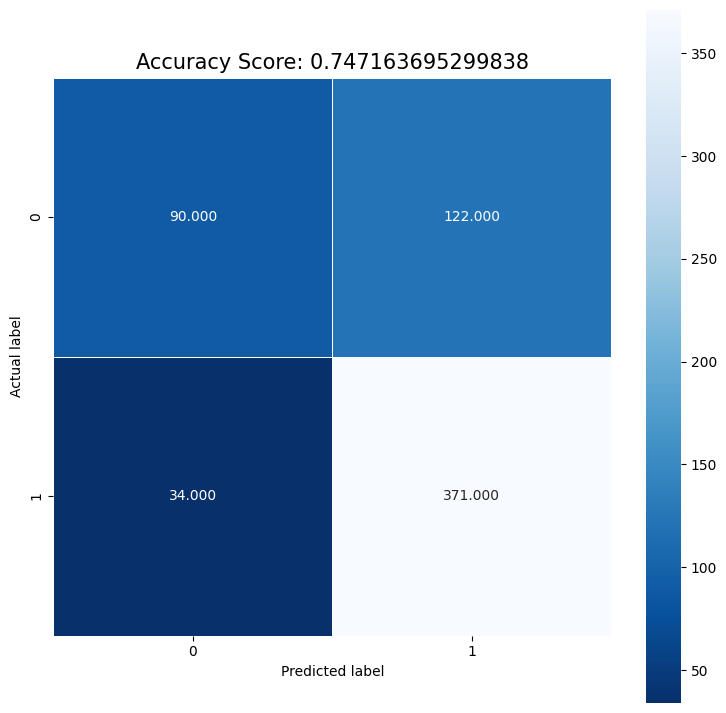

In [556]:
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

In [557]:
accuracy = (cm[0,0] + cm[1,1])/(cm[0,0] + cm[0,1] + cm[1,0] + cm[1,1])
print(accuracy)

0.747163695299838


In [558]:
precision = (cm[1,1])/(cm[0,1] + cm[1,1])
print(precision)

0.7525354969574036


Kalau salah predict --> yang awalnya dikira late, ternyata ga late, malah bagus dong

In [559]:
recall = (cm[1,1])/(cm[1,0] + cm[1,1])
print(recall)

0.9160493827160494


Kalau gagal discover sebanyak mungkin item yang late, jadinya banyak factor yang tidak performant --> Recall adalah metrics yang lebih bagus

In [560]:
precision_2 = (cm[0,0])/(cm[0,0] + cm[1,0])
print(precision_2)

0.7258064516129032


In [561]:
recall_2 = (cm[0,0])/(cm[0,0] + cm[0,1])
print(recall_2)

0.42452830188679247


## BATAS AKHIR

In [156]:
# filter = (df['Disputed'] == 'No') & (df['DaysLate'] > 0)
# disputed_but_on_time = df.loc[filter].shape[0]

# print(disputed_but_on_time)

In [157]:
# df.loc[filter]

In [6]:
# filter = (df['DaysLate'] > 0)
# df.loc[filter].shape[0]

In [ ]:
# def get_y_m_dow(data, column):
#     year = data[column].dt.strftime('%Y')
#     month = data[column].dt.strftime('%m')
#     day = data[column].dt.strftime('%w')
    
#     data = data.drop(column, axis=1)
    
#     return data, year, month, day
    

In [ ]:
# # Get the Year, Month, and Day of Weekk of Paperless Date
# df, df['paperless_year'], df['paperless_month'], df['paperless_dow'] = get_y_m_dow(df, 'paperless_date')
# df.head()

In [ ]:
# # Get the Year, Month, and Day of Weekk of Invoice Date
# df, df['invoice_year'], df['invoice_month'], df['invoice_dow'] = get_y_m_dow(df, 'invoice_date')
# df.head()

In [ ]:
# # Get the Year, Month, and Day of Weekk of Due Date
# df, df['due_year'], df['due_month'], df['due_dow'] = get_y_m_dow(df, 'due_date')
# df.head()